In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

## Imports and declarations

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from quicknat import QuickNat
from utils.data_utils import get_data
from utils.log_utils import LogWriter
import utils.evaluator as eu
from settings import Settings
from solver import Solver

%matplotlib inline
%load_ext autoreload
%autoreload 2

settings = Settings()
common_params, data_params, net_params, train_params, eval_params = settings['COMMON'], settings['DATA'], settings['NETWORK'], settings['TRAINING'], settings['EVAL']

# Train QuickNAT

## 1. Load Training and Validation Data

In [3]:
train_data, test_data = get_data(data_params)
print("Train size: %i" % len(train_data))
print("Test size: %i" % len(test_data))

Train size: 1083
Test size: 1032


## 2. Train Model

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=train_params['train_batch_size'], shuffle=True, num_workers=4, pin_memory = True)
val_loader = torch.utils.data.DataLoader(test_data, batch_size=train_params['val_batch_size'], shuffle=False, num_workers=4, pin_memory = True)

quicknat_model = QuickNat(net_params)

solver = Solver(quicknat_model,
                device = common_params['device'],
                num_class = net_params['num_class'],
                optim_args={"lr": train_params['learning_rate'],
                            "betas": train_params['optim_betas'], 
                            "eps": train_params['optim_eps'], 
                            "weight_decay": train_params['optim_weight_decay']},
                model_name = common_params['model_name'],
                labels = data_params['labels'],
                log_nth=train_params['log_nth'], 
                num_epochs=train_params['num_epochs'], 
                log_dir_name = common_params['log_dir_name'],
                exp_dir_name=train_params['exp_dir_name'], 
                lr_scheduler_step_size = train_params['lr_scheduler_step_size'], 
                lr_scheduler_gamma = train_params['lr_scheduler_gamma'],
                use_last_checkpoint =train_params['use_last_checkpoint'],
                save_model_dir = common_params['save_model_dir'])

solver.train(train_loader, val_loader)

=> no checkpoint found at 'saved_models/Exp01_try8/checkpoint.pth.tar'
START TRAINING.

==== Epoch [1 / 10] START ====
<<<= Phase: train =>>>
[Iteration : 0] Loss -> 1.45625901222229
[Iteration : 50] Loss -> 0.8849115371704102
[Iteration : 100] Loss -> 0.7836363911628723
epoch train loss = 0.7832725644111633
Sample Images...DONE
Confusion Matrix...DONE
<<<= Phase: val =>>>
########################################################################################################
epoch val loss = 0.889864980601
Sample Images...DONE
Confusion Matrix...DONE
Dice Score...DONE
==== Epoch [1 / 10] DONE ====

==== Epoch [2 / 10] START ====
<<<= Phase: train =>>>
[Iteration : 0] Loss -> 0.7638850212097168
[Iteration : 50] Loss -> 0.633151113986969
[Iteration : 100] Loss -> 0.46823230385780334
epoch train loss = 0.6386333703994751
Sample Images...DONE
Confusion Matrix...DONE
<<<= Phase: val =>>>
#######################################################################################################

# Save the Model

When you are satisfied with your training, you can save the model.

In [27]:
quicknat_model.save(train_params['final_model_path'])

Saving model... models/quicknat_final.pth.tar


# Evaluate Model

## 1. Calculate dice score of each volume

In [19]:
eval_model_path = eval_params['eval_model_path']
num_classes = net_params['num_class']
labels = data_params['labels']
data_dir = eval_params['data_dir']
label_dir = eval_params['label_dir']
volumes_txt_file = eval_params['volumes_txt_file']
remap_config = eval_params['remap_config']
device = common_params['device']
log_dir_name = common_params['log_dir_name']
exp_dir_name = train_params['exp_dir_name']
orientation = eval_params['orientation']

logWriter = LogWriter(num_classes, log_dir_name, exp_dir_name, labels=labels)

avg_dice_score, volume_dice_score_list = eu.evaluate_dice_score(eval_model_path, 
                                                                num_classes, 
                                                                data_dir, 
                                                                label_dir, 
                                                                volumes_txt_file , 
                                                                remap_config, 
                                                                orientation, 
                                                                device, 
                                                                logWriter)

**Starting evaluation on the volumes. Please check tensorboard for dice score plots if a logWriter is provided in arguments**
Loading data volumes
Data loaded succssfully
Volume 0 evaluated
Volume 1 evaluated
Volume 2 evaluated
Volume 3 evaluated
Volume 4 evaluated
Volume 5 evaluated
Volume 6 evaluated
Volume 7 evaluated
Volume 8 evaluated
Volume 9 evaluated
Volume 10 evaluated
Volume 11 evaluated
Volume 12 evaluated
Volume 13 evaluated
Volume 14 evaluated
**End**


## 2. Plot average dice score of all the volumes

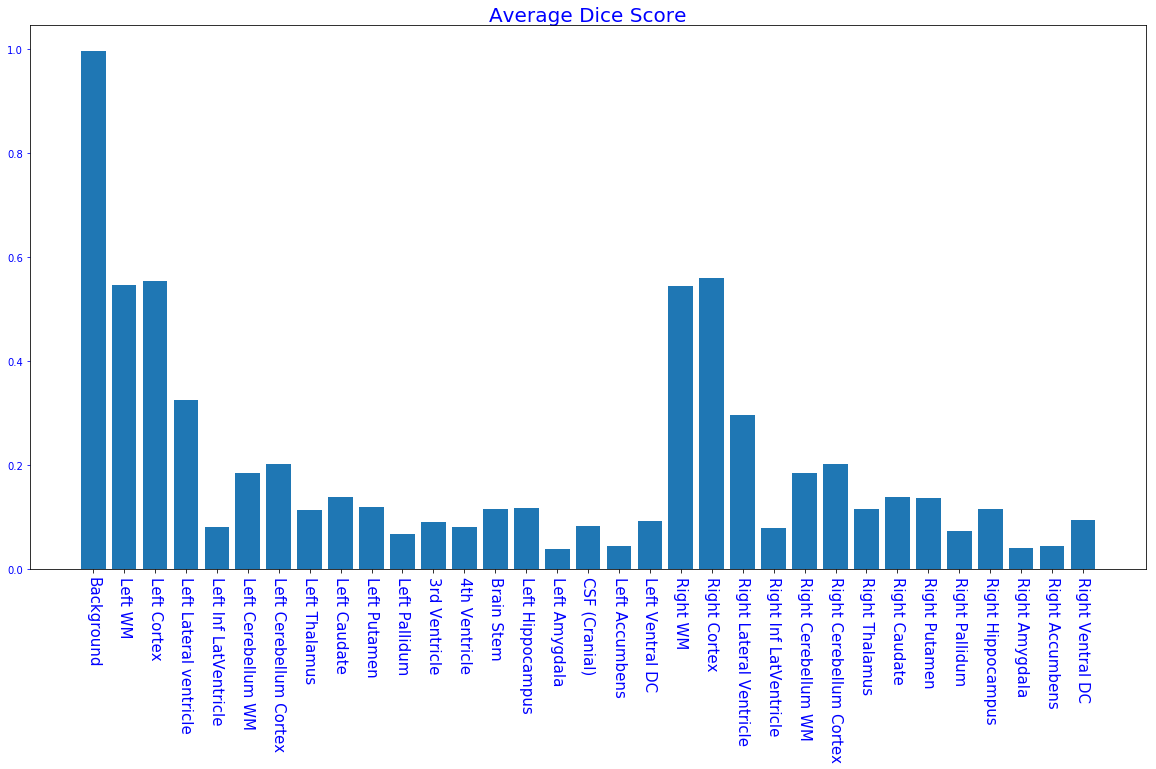

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(20,10))
ax.bar(np.arange(num_classes), avg_dice_score)
ax.set_xlabel('Average Dice Score', fontsize=20, color='blue')        
ax.set_xticks(np.arange(num_classes))
c = ax.set_xticklabels(labels, fontsize=15, rotation=-90,  ha='center', color='blue')
ax.xaxis.set_label_position('top')
ax.tick_params(axis='y', colors='blue')
ax.xaxis.tick_bottom()
plt.show()

# Test

## 1. Load test model

In [ ]:
quick_model_test = torch.load(train_params['final_model_path'], map_location=torch.device(common_params['device']))

## 2. Predict a few sample slices

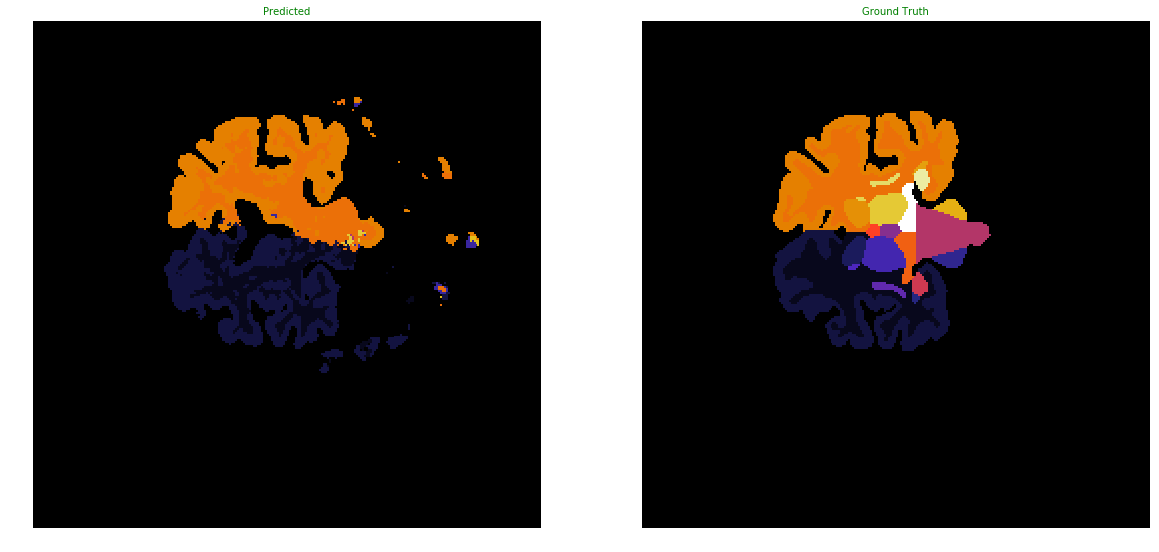

In [30]:
with torch.no_grad():
    test_input = torch.tensor(test_data.X[1000:1001])
    out = quick_model_test.predict(test_input, common_params['device'])
    
groud_truth = test_data.y[1000:1001]
groud_truth = np.squeeze(groud_truth)    

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,20))
ax[0].imshow(out, cmap ='CMRmap', vmin=0, vmax=net_params['num_class']-1)

ax[0].set_title("Predicted", fontsize=10, color = "green")
ax[0].axis('off')
ax[1].imshow(groud_truth, cmap ='CMRmap', vmin=0, vmax=net_params['num_class']-1)
ax[1].set_title("Ground Truth", fontsize=10, color = "green")
ax[1].axis('off')
plt.show()